<a href="https://colab.research.google.com/github/DCM2002/ML_CW_2410214/blob/main/ML_CW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Necessary Libraries**

In [42]:
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, f_oneway
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [43]:
# Input dataset CSV file
input_file = "/content/bank-additional-full.csv"

# Read and process the CSV file with semicolon-delimited rows
with open(input_file, mode="r", newline="", encoding="utf-8") as file:
    reader = csv.reader(file, delimiter=';')  # Use semicolon as the limit

    # Read the header
    header = next(reader, None)
    if header:
        print("Header:", header)

    # Split each row into columns
    for row in reader:
        print(row)

# Save processed rows to a new CSV file
output_file = "cleaned-bank-additional-full-data.csv"

with open(input_file, mode="r", newline="", encoding="utf-8") as infile, \
     open(output_file, mode="w", newline="", encoding="utf-8") as outfile:

    reader = csv.reader(infile, delimiter=';')
    writer = csv.writer(outfile)

    for row in reader:
        writer.writerow(row)  # Write each processed row to the output CSV file

print(f"Newly structures data has been written to {output_file}")

Streaming output truncated to the last 5000 lines.
['38', 'management', 'married', 'university.degree', 'no', 'yes', 'no', 'cellular', 'may', 'wed', '187', '2', '2', '1', 'success', '-1.8', '92.893', '-46.2', '1.27', '5099.1', 'yes']
['32', 'technician', 'married', 'university.degree', 'no', 'yes', 'no', 'telephone', 'may', 'wed', '186', '2', '999', '0', 'nonexistent', '-1.8', '92.893', '-46.2', '1.27', '5099.1', 'no']
['36', 'technician', 'married', 'professional.course', 'no', 'yes', 'no', 'telephone', 'may', 'wed', '86', '4', '999', '0', 'nonexistent', '-1.8', '92.893', '-46.2', '1.27', '5099.1', 'no']
['48', 'technician', 'married', 'basic.6y', 'no', 'yes', 'no', 'cellular', 'may', 'thu', '158', '2', '999', '0', 'nonexistent', '-1.8', '92.893', '-46.2', '1.27', '5099.1', 'no']
['30', 'management', 'married', 'university.degree', 'no', 'no', 'no', 'cellular', 'may', 'thu', '162', '7', '999', '0', 'nonexistent', '-1.8', '92.893', '-46.2', '1.27', '5099.1', 'no']
['24', 'management', 

In [44]:
# Load the dataset
data = pd.read_csv('/content/cleaned-bank-additional-full-data.csv')

# Display the first few rows of the dataset
print(data.head())


   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

In [45]:
#Display the count of "unknown" values for each feature
unknown_counts = data.apply(lambda x: (x == 'unknown').sum() if x.dtype == 'object' else 0)
print("Count of 'unknown' values for each feature:\n", unknown_counts)

#Replace null values with "unknown"
data.fillna('unknown', inplace=True)


Count of 'unknown' values for each feature:
 age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64


In [46]:
#Duplicate rows
duplicates = data[data.duplicated(keep=False)]
print("Duplicate rows:\n", duplicates)
print("Count of duplicate rows:", duplicates.shape[0])

Duplicate rows:
        age          job   marital            education  default housing loan  \
1265    39  blue-collar   married             basic.6y       no      no   no   
1266    39  blue-collar   married             basic.6y       no      no   no   
12260   36      retired   married              unknown       no      no   no   
12261   36      retired   married              unknown       no      no   no   
14155   27   technician    single  professional.course       no      no   no   
14234   27   technician    single  professional.course       no      no   no   
16819   47   technician  divorced          high.school       no     yes   no   
16956   47   technician  divorced          high.school       no     yes   no   
18464   32   technician    single  professional.course       no     yes   no   
18465   32   technician    single  professional.course       no     yes   no   
20072   55     services   married          high.school  unknown      no   no   
20216   55     services

## **Visualizing Numeric Data**

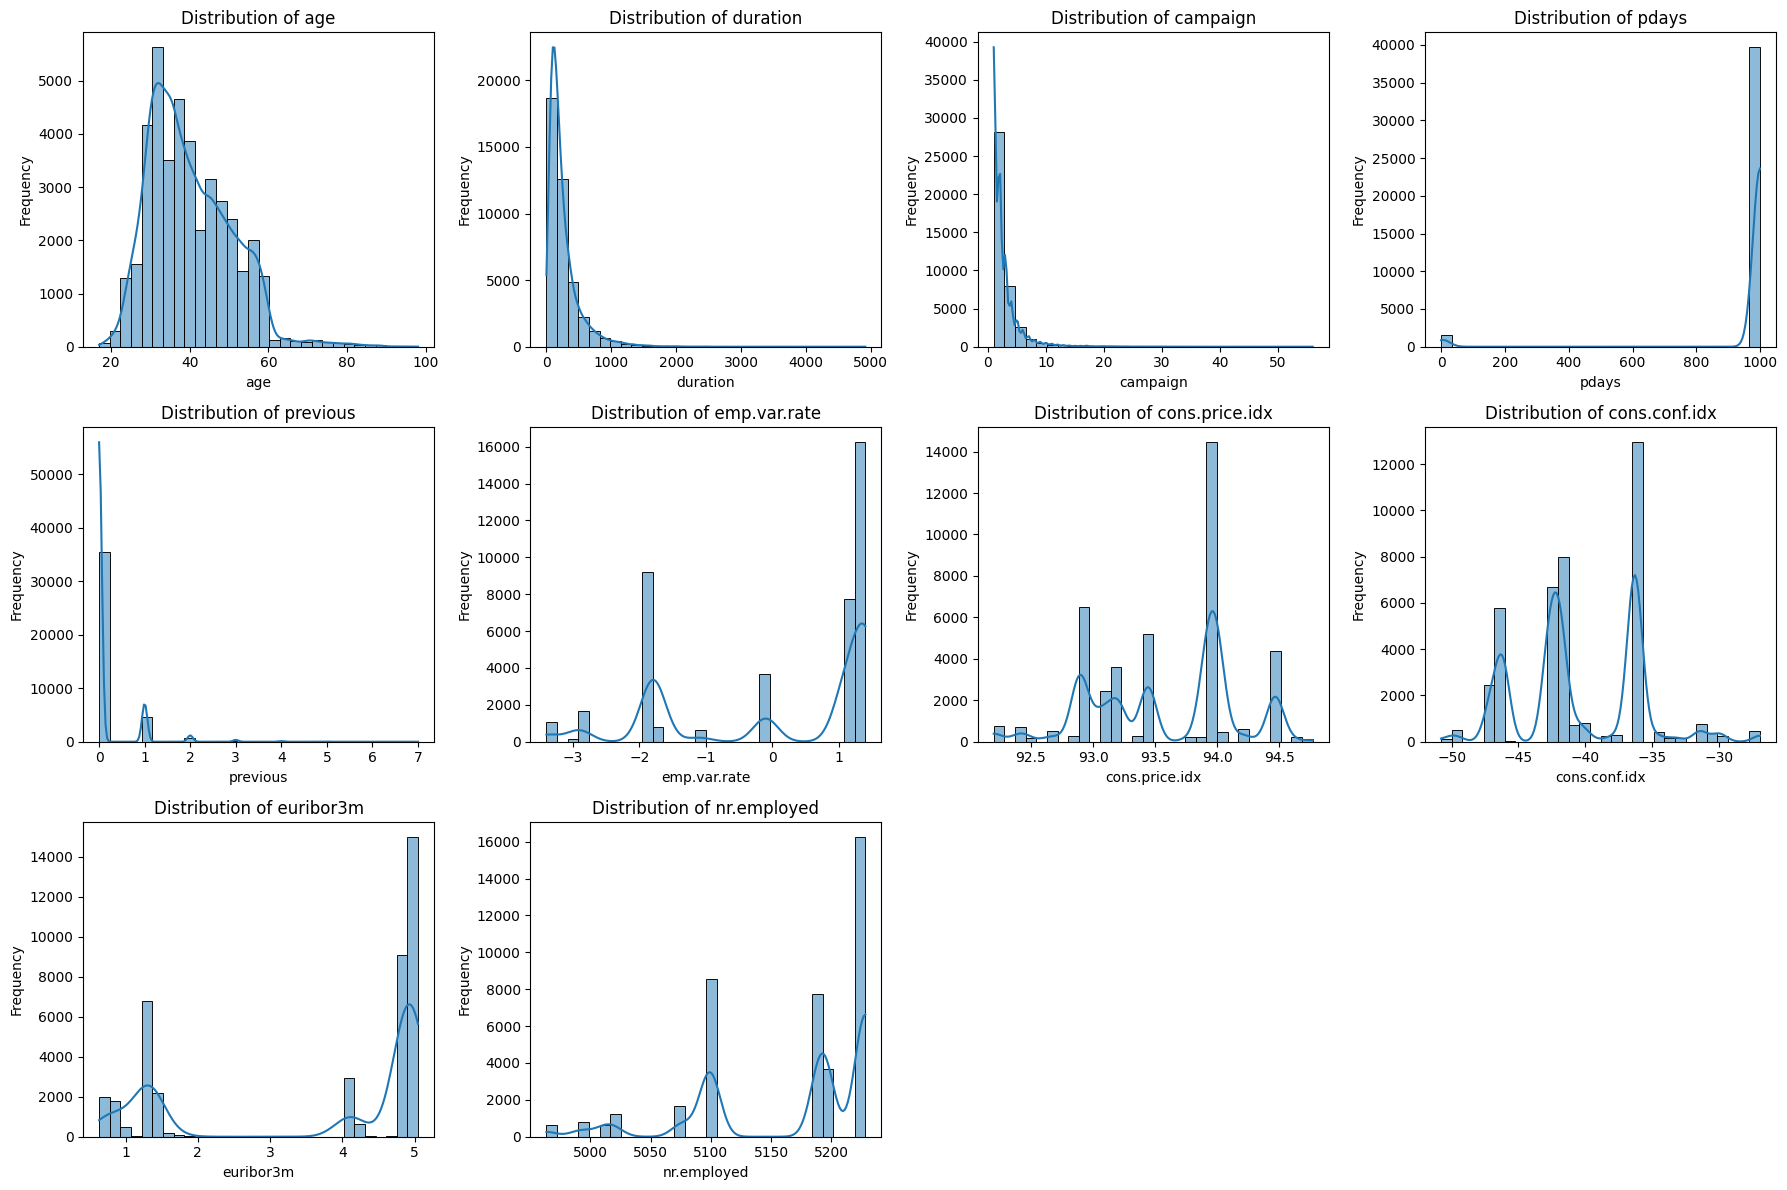

In [6]:
# List of numerical features
numerical_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

#Histograms for each numerical feature
plt.figure(figsize=(18, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## **Age Feature Analysis**

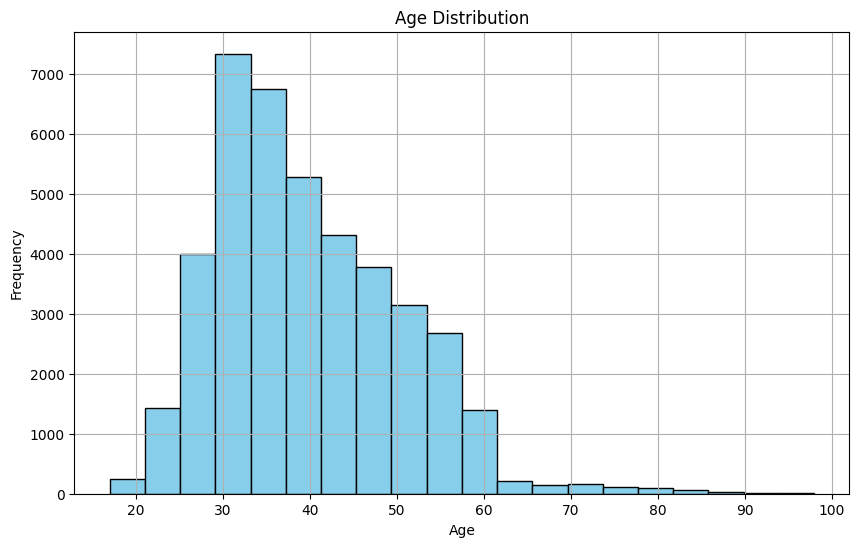

<ipython-input-7-66ca8b6b5e4a>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='poutcome', y='age', palette=palette)


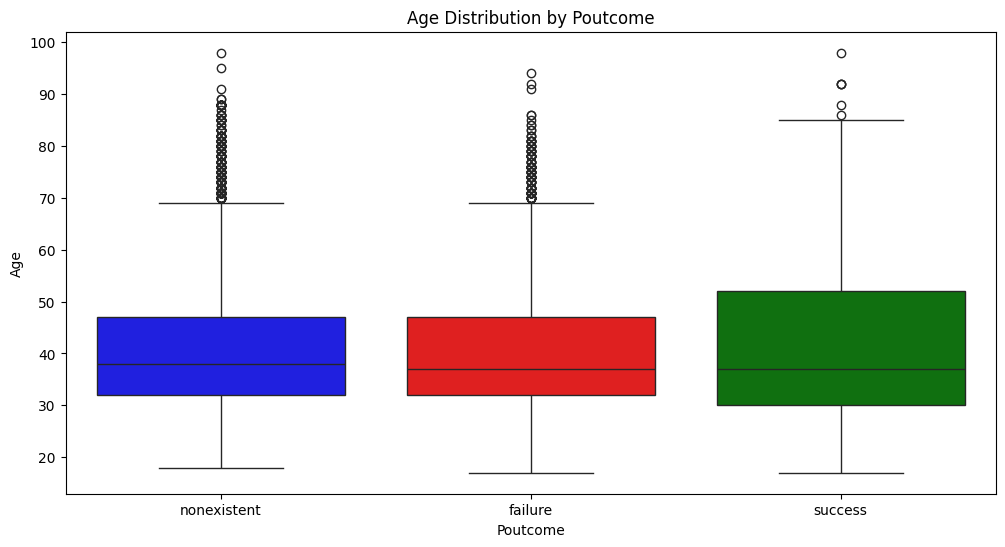

In [7]:
# Plot Age histogram
plt.figure(figsize=(10, 6))
plt.hist(data['age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.grid(True)
plt.show()

# Define a color palette for the poutcome categories - after fixing outlier
palette = {'failure': 'red', 'nonexistent': 'blue', 'success': 'green'}

# Plot box plot of age distribution by poutcome- before fixing outlier
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='poutcome', y='age', palette=palette)
plt.title('Age Distribution by Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Age')
plt.show()


In [8]:
data.loc[data['age'] >=80]['age'].value_counts()

,count
age,
80,31
88,22
81,20
82,17
83,17
85,15
86,8
84,7
92,4


In [9]:
# Calculate average age for 86-94
age_avg = data[(data['age'] >= 84) & (data['age'] <= 95)]['age'].mean()

# Make it whole number
age_avg = round(age_avg)
print(age_avg)

# Fill ages between 82-90 with average age
data.loc[(data['age'] >= 86) & (data['age'] <= 94), 'age'] = age_avg

87


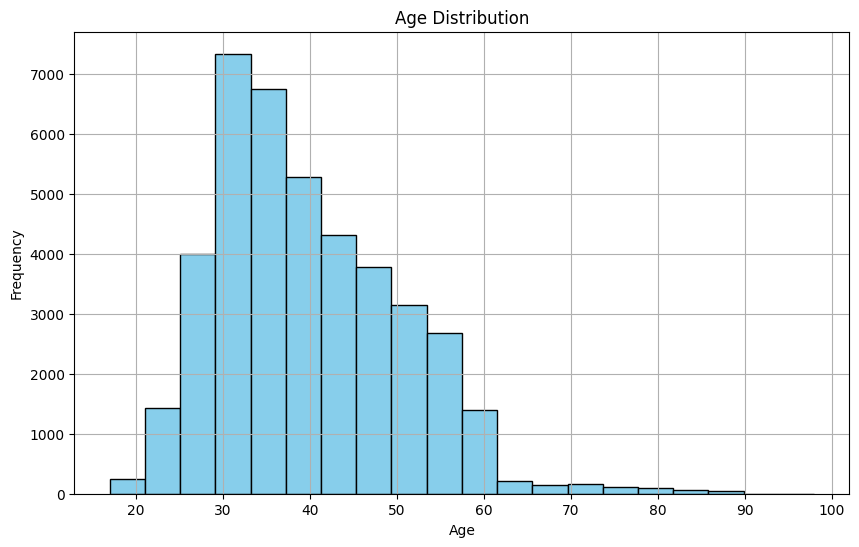

<ipython-input-10-c4dc8526c5fc>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='poutcome', y='age', palette=palette)


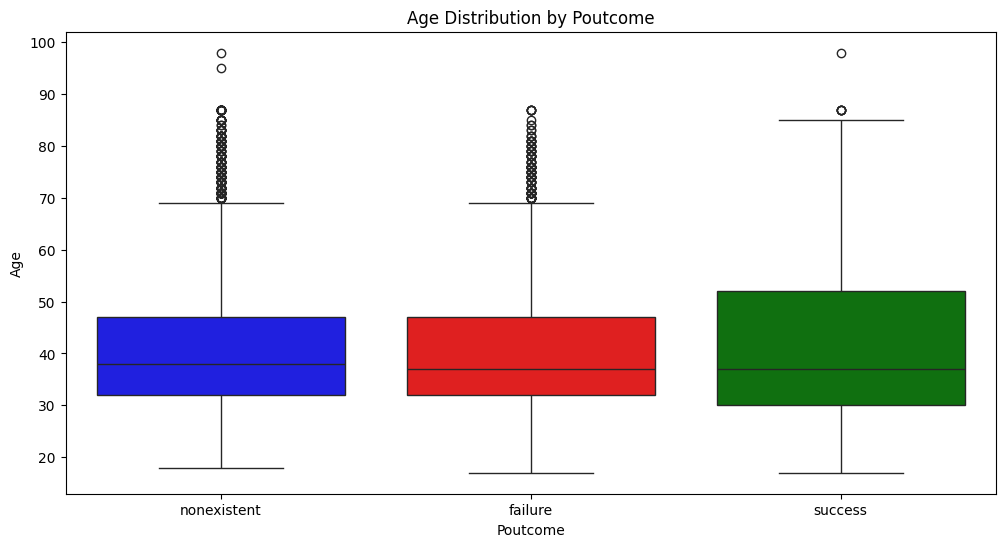

In [10]:
#Age histogram after handling outlier
plt.figure(figsize=(10, 6))
plt.hist(data['age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.grid(True)
plt.show()

# Define a color palette for the poutcome categories - after fixing outlier
palette = {'failure': 'red', 'nonexistent': 'blue', 'success': 'green'}

# Plot box plot of age distribution by poutcome
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='poutcome', y='age', palette=palette)
plt.title('Age Distribution by Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Age')
plt.show()

## **Age Feature- Cat.Feature co-relation**

job (ANOVA): F-statistic = 1278.459612677654, p-value = 0.0, Significance = Highly significant
marital (ANOVA): F-statistic = 2923.490733184533, p-value = 0.0, Significance = Highly significant
education (ANOVA): F-statistic = 457.04346223451046, p-value = 0.0, Significance = Highly significant
default (ANOVA): F-statistic = 577.5812427042049, p-value = 4.102328072074933e-248, Significance = Highly significant
housing (ANOVA): F-statistic = 0.0747274016323667, p-value = 0.9279965479852897, Significance = Not significant
loan (ANOVA): F-statistic = 1.1406142121833298, p-value = 0.3196327418063181, Significance = Not significant


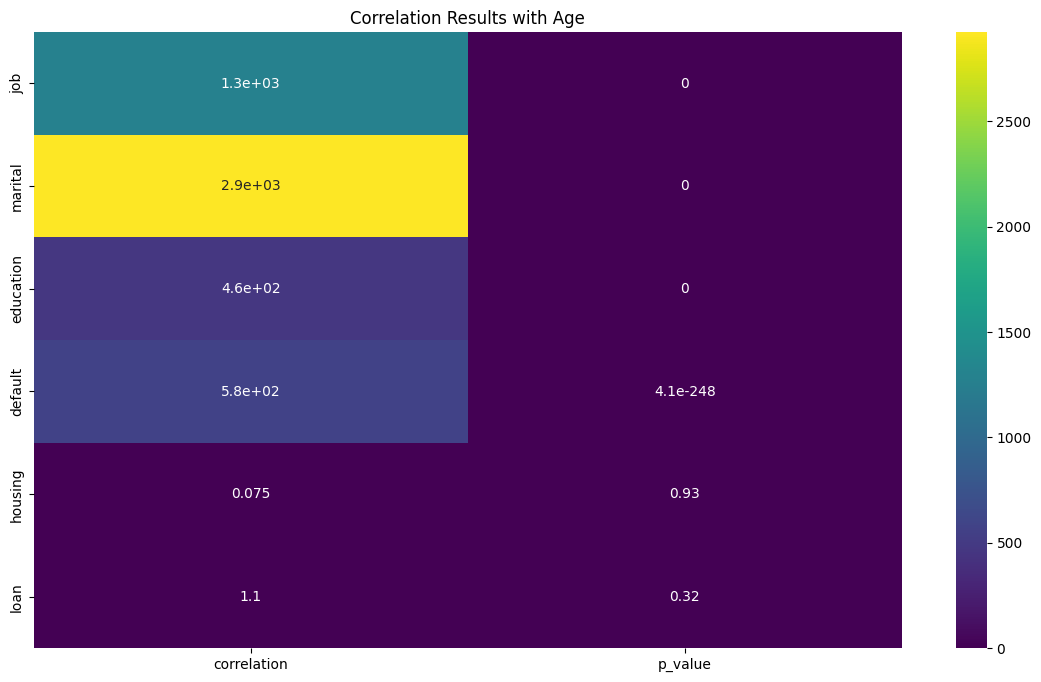

Significance Levels:
     Feature        Significance
0        job  Highly significant
1    marital  Highly significant
2  education  Highly significant
3    default  Highly significant
4    housing     Not significant
5       loan     Not significant


In [11]:
# List of categorical features to analyze
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# Dictionary to store the correlation results
correlation_results = {}

# Function to calculate Point-Biserial Correlation for binary categorical variables
def calculate_point_biserial(feature):
    binary_feature = data[feature].apply(lambda x: 1 if x == 'yes' else 0)
    corr, p_value = pointbiserialr(binary_feature, data['age'])
    return corr, p_value

# Function to calculate ANOVA for multi-class categorical variables
def calculate_anova(feature):
    categories = data[feature].unique()
    groups = [data[data[feature] == category]['age'] for category in categories]
    f_stat, p_value = f_oneway(*groups)
    return f_stat, p_value

# Function to categorize p-value significance
def categorize_p_value(p_value):
    if p_value < 0.01:
        return 'Highly significant'
    elif p_value < 0.05:
        return 'Significant'
    elif p_value < 0.10:
        return 'Marginally significant'
    else:
        return 'Not significant'

# Calculate correlations for each categorical feature
for feature in categorical_features:
    if data[feature].nunique() == 2:  # Binary categorical variable
        corr, p_value = calculate_point_biserial(feature)
        significance = categorize_p_value(p_value)
        correlation_results[feature] = {'correlation': corr, 'p_value': p_value, 'significance': significance}
    else:  # Multi-class categorical variable
        f_stat, p_value = calculate_anova(feature)
        significance = categorize_p_value(p_value)
        correlation_results[feature] = {'F-statistic': f_stat, 'p_value': p_value, 'significance': significance}

# Print the correlation results
for feature, results in correlation_results.items():
    if 'correlation' in results:
        print(f"{feature} (Point-Biserial Correlation): Correlation = {results['correlation']}, p-value = {results['p_value']}, Significance = {results['significance']}")
    else:
        print(f"{feature} (ANOVA): F-statistic = {results['F-statistic']}, p-value = {results['p_value']}, Significance = {results['significance']}")

# Separate the numerical values and significance levels
numerical_results = {feature: {'correlation': results.get('correlation', results.get('F-statistic', None)), 'p_value': results['p_value']} for feature, results in correlation_results.items()}
significance_results = {feature: results['significance'] for feature, results in correlation_results.items()}

# Convert to DataFrames
numerical_df = pd.DataFrame(numerical_results).T
significance_df = pd.DataFrame(list(significance_results.items()), columns=['Feature', 'Significance'])

# Visualize the numerical results
plt.figure(figsize=(14, 8))
sns.heatmap(numerical_df, annot=True, cmap='viridis')
plt.title('Correlation Results with Age')
plt.show()

# Print the significance results
print("Significance Levels:")
print(significance_df)


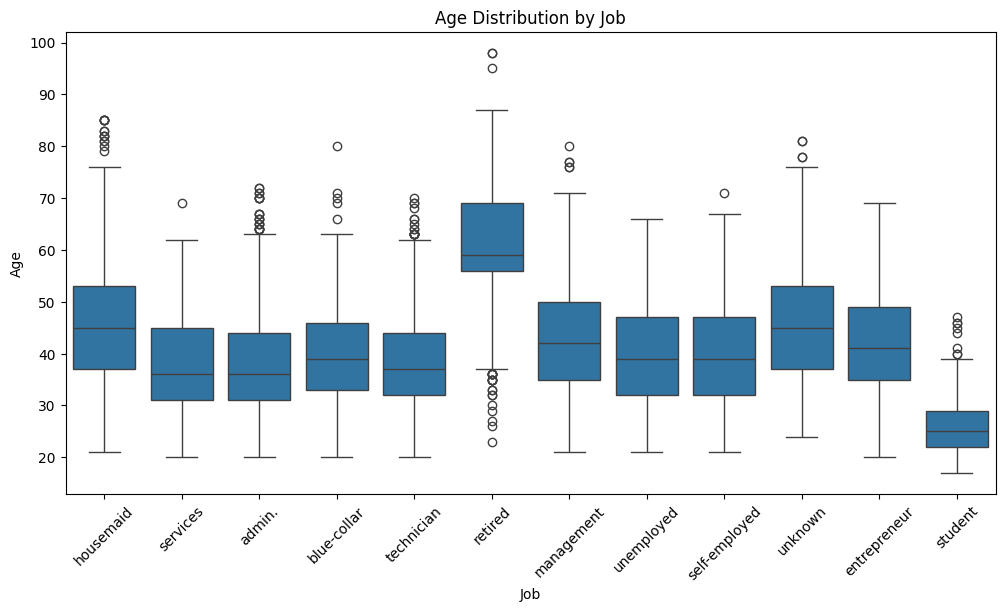

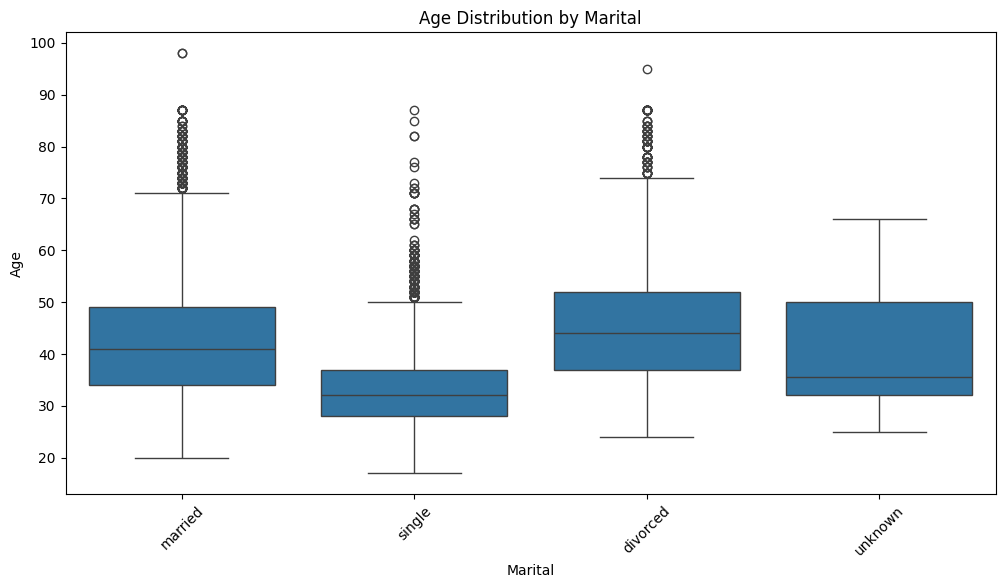

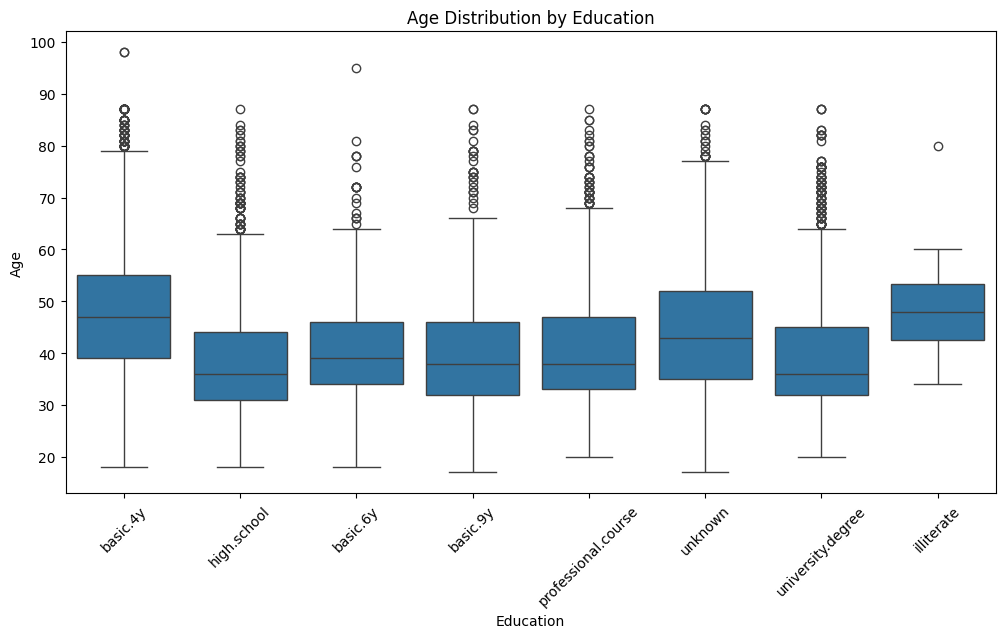

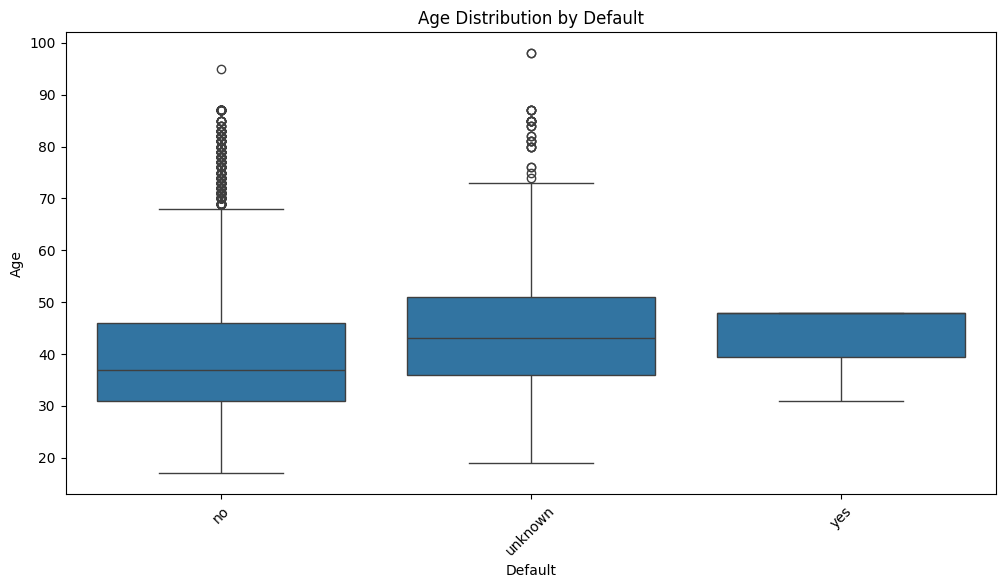

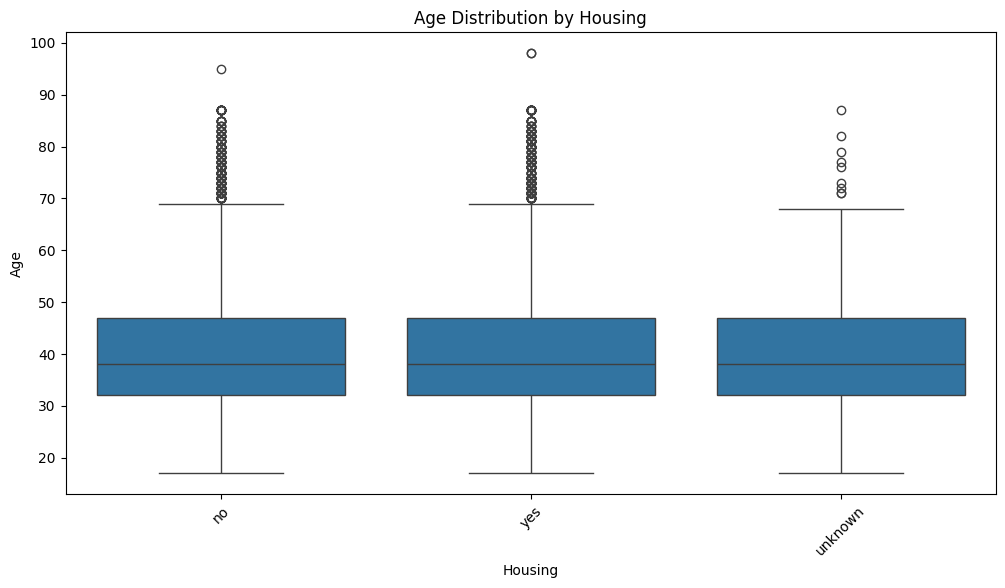

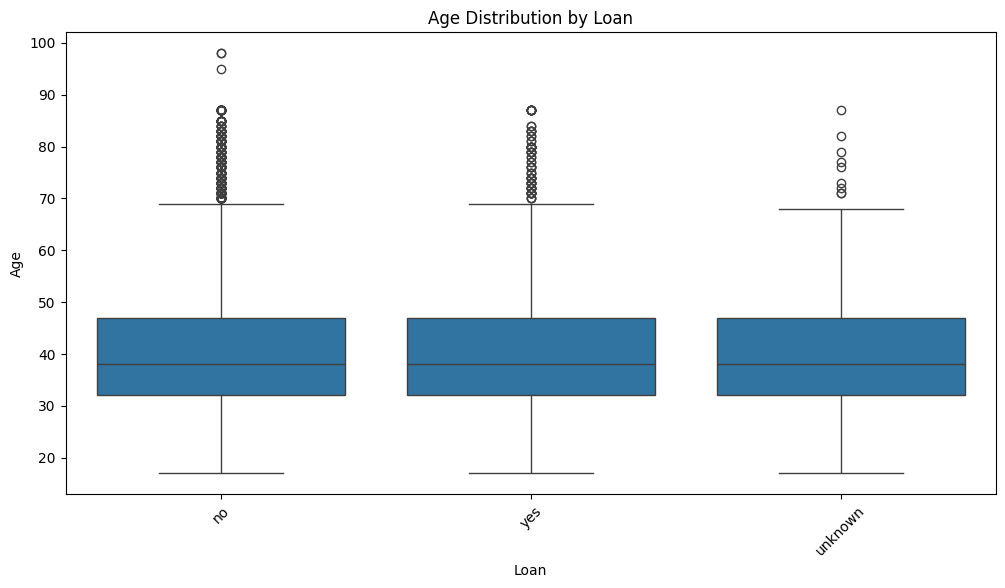

In [12]:
# List of categorical features
categorical_features = ['job', 'marital', 'education', 'default','housing','loan']

# Plot box plots for each categorical feature
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data, x=feature, y='age')
    plt.title(f'Age Distribution by {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Age')
    plt.xticks(rotation=45)
    plt.show()


In [13]:
# Define age bins
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Classify age into bins
data['age_bin'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

<ipython-input-14-02e14bda226d>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  most_frequent_job = data.groupby('age_bin')['job'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown')


Most frequent job category for each age bin:
 age_bin
0-20          student
21-30          admin.
31-40          admin.
41-50     blue-collar
51-60     blue-collar
61-70         retired
71-80         retired
81-90         retired
91-100        retired
Name: job, dtype: object
Job distribution after replacement:
 job
admin.           10520
blue-collar       9457
technician        6743
services          3969
management        2924
retired           1749
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: count, dtype: int64


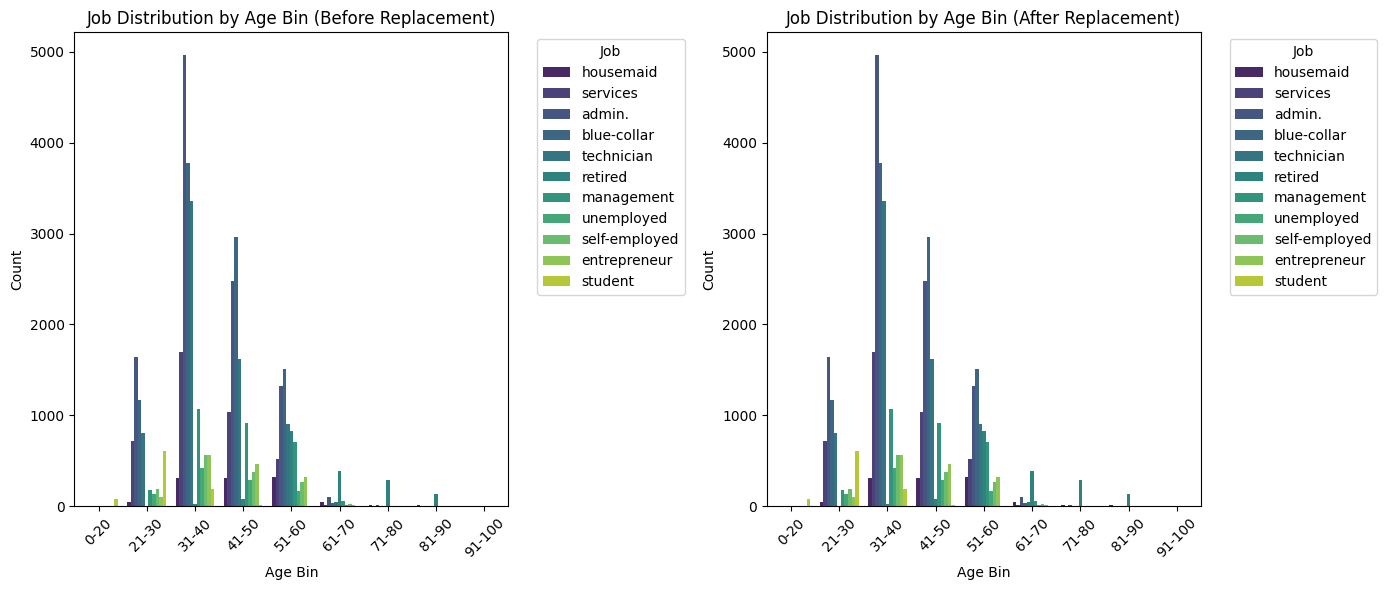

In [14]:
#Job-Age


# Determine the most frequent job category for each age bin
most_frequent_job = data.groupby('age_bin')['job'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown')

# Print the most frequent job category for each age bin
print("Most frequent job category for each age bin:\n", most_frequent_job)

# Function to replace 'unknown' labels based on age bin
def replace_unknown_job(row):
    if row['job'] == 'unknown':
        return most_frequent_job[row['age_bin']]
    return row['job']

# Replace 'unknown' labels in 'job'
data['job'] = data.apply(replace_unknown_job, axis=1)

# Verify the changes
print("Job distribution after replacement:\n", data['job'].value_counts())

# Visualize the job distribution before and after replacement
plt.figure(figsize=(14, 6))

# Before replacement
plt.subplot(1, 2, 1)
sns.countplot(data=data[data['job'] != 'unknown'], x='age_bin', hue='job', palette='viridis')
plt.title('Job Distribution by Age Bin (Before Replacement)')
plt.xlabel('Age Bin')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Job', bbox_to_anchor=(1.05, 1), loc='upper left')

# After replacement
plt.subplot(1, 2, 2)
sns.countplot(data=data, x='age_bin', hue='job', palette='viridis')
plt.title('Job Distribution by Age Bin (After Replacement)')
plt.xlabel('Age Bin')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Job', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


<ipython-input-15-b04758c6709f>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  most_frequent_default = data.groupby('age_bin')['default'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown')


Most frequent answer for each age bin:
 age_bin
0-20           no
21-30          no
31-40          no
41-50          no
51-60          no
61-70          no
71-80          no
81-90          no
91-100    unknown
Name: default, dtype: object
Default distribution after replacement:
 default
no         41183
yes            3
unknown        2
Name: count, dtype: int64


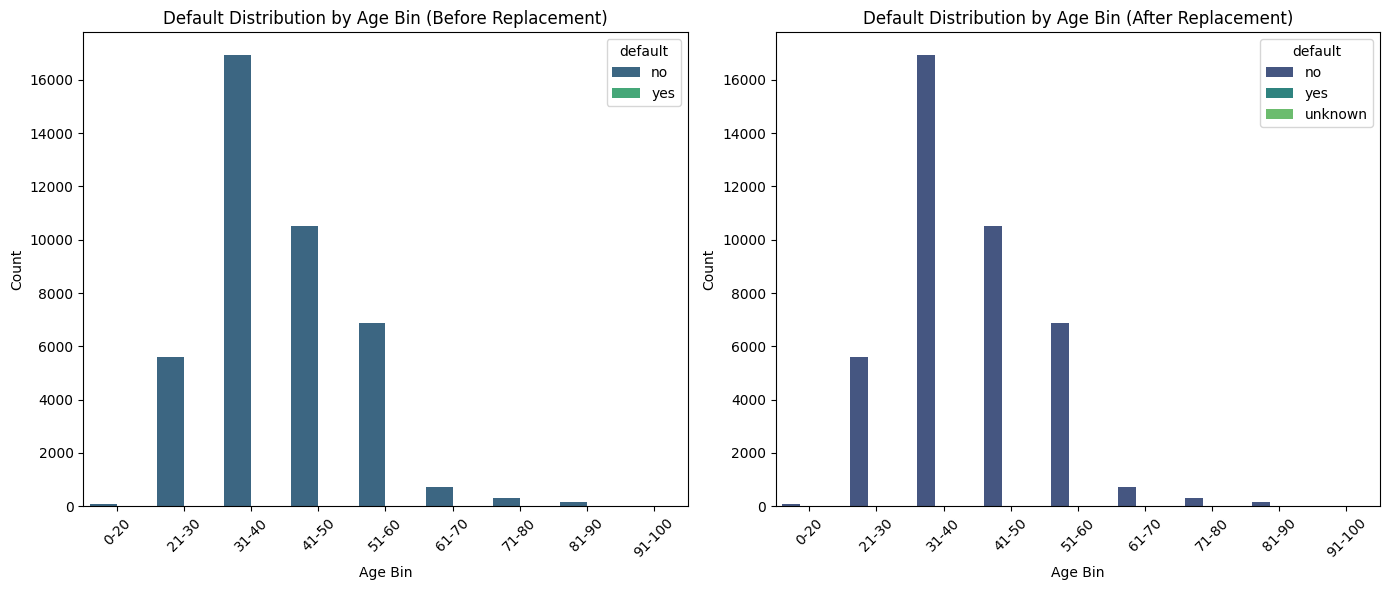

In [15]:
#Default-Age


# Determine the most frequent answer for each age bin
most_frequent_default = data.groupby('age_bin')['default'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown')

# Print the most frequent answer for each age bin
print("Most frequent answer for each age bin:\n", most_frequent_default)

# Function to replace 'unknown' labels based on age bin
def replace_unknown_default(row):
    if row['default'] == 'unknown':
        return most_frequent_default[row['age_bin']]
    return row['default']

# Replace 'unknown' labels in 'default'
data['default'] = data.apply(replace_unknown_default, axis=1)

# Verify the changes
print("Default distribution after replacement:\n", data['default'].value_counts())

# Visualize the default distribution before and after replacement
plt.figure(figsize=(14, 6))

# Before replacement
plt.subplot(1, 2, 1)
sns.countplot(data=data[data['default'] != 'unknown'], x='age_bin', hue='default', palette='viridis')
plt.title('Default Distribution by Age Bin (Before Replacement)')
plt.xlabel('Age Bin')
plt.ylabel('Count')
plt.xticks(rotation=45)

# After replacement
plt.subplot(1, 2, 2)
sns.countplot(data=data, x='age_bin', hue='default', palette='viridis')
plt.title('Default Distribution by Age Bin (After Replacement)')
plt.xlabel('Age Bin')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


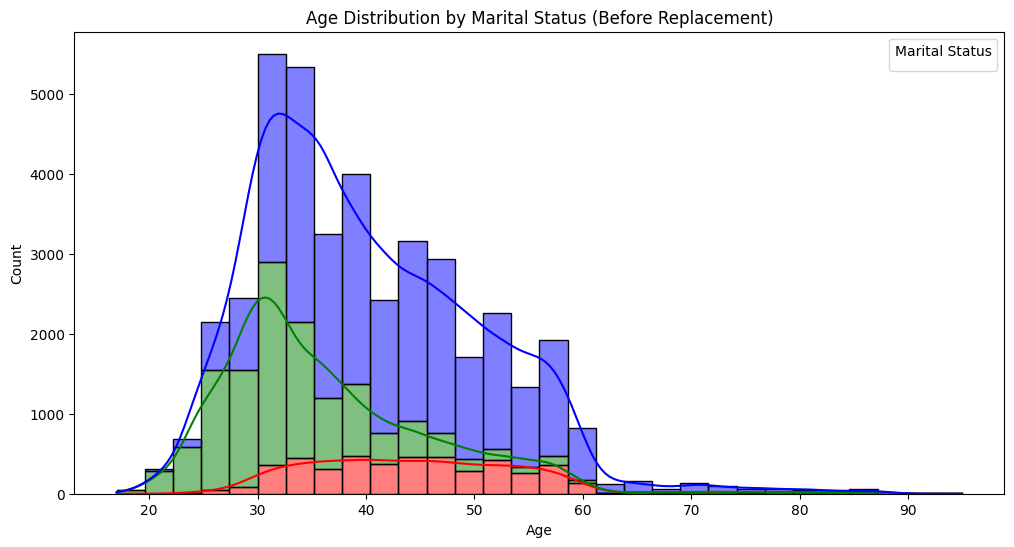

Average age for different marital statuses:
 {'divorced': 44.94570135746606, 'married': 42.29654729919397, 'single': 33.19053796920948}
Count of 'unknown' values in 'marital' after replacement: 0
Marital status distribution after replacement:
 marital
married     24937
single      11562
divorced     4641
Name: count, dtype: int64


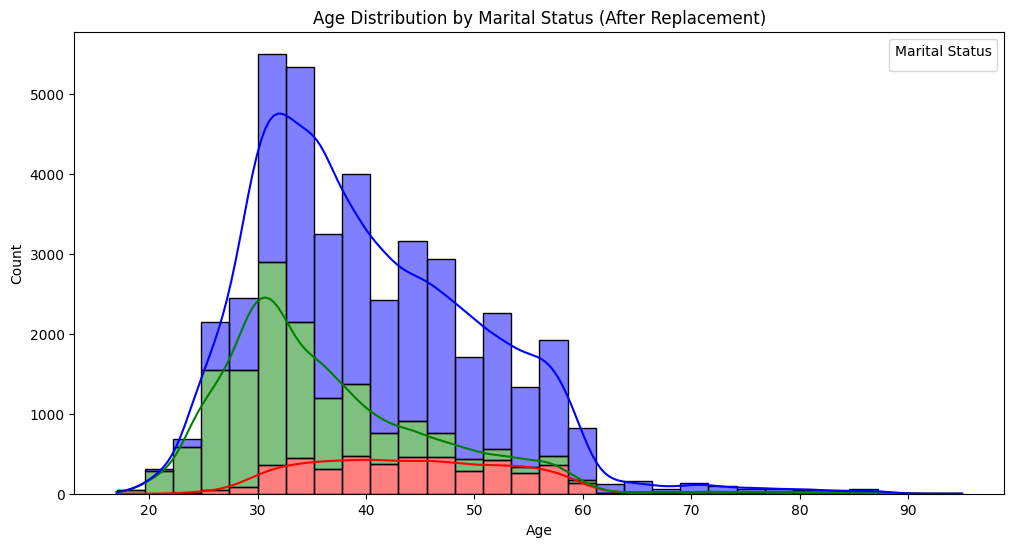

In [28]:
#Marital-Age

# Define a color palette for the marital statuses
palette = {'married': 'blue', 'single': 'green', 'divorced': 'red', 'unknown': 'gray'}

# Plot histogram of age distribution by marital status before replacement
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='age', hue='marital', multiple='stack', bins=30, kde=True, palette=palette)
plt.title('Age Distribution by Marital Status (Before Replacement)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Marital Status')
plt.show()

# Determine the age ranges for different marital statuses
age_ranges = {
    'divorced': data[data['marital'] == 'divorced']['age'].mean(),
    'married': data[data['marital'] == 'married']['age'].mean(),
    'single': data[data['marital'] == 'single']['age'].mean()
}

print("Average age for different marital statuses:\n", age_ranges)

# Replace 'unknown' labels in 'marital' based on age ranges
def replace_unknown_marital(row):
    if row['marital'] == 'unknown':
        if row['age'] < age_ranges['single']:
            return 'single'
        elif row['age'] < age_ranges['married']:
            return 'married'
        else:
            return 'divorced'
    return row['marital']

data['marital'] = data.apply(replace_unknown_marital, axis=1)

# Check the count of 'unknown' values after replacement
unknown_counts_after = data['marital'].value_counts().get('unknown', 0)
print("Count of 'unknown' values in 'marital' after replacement:", unknown_counts_after)

# Verify the changes
print("Marital status distribution after replacement:\n", data['marital'].value_counts())

# Plot histogram of age distribution by marital status after replacement
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='age', hue='marital', multiple='stack', bins=30, kde=True, palette=palette)
plt.title('Age Distribution by Marital Status (After Replacement)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Marital Status')
plt.show()


<ipython-input-29-078f6531f733>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  most_frequent_education = data.groupby('age_bin')['education'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown')


Most frequent education category for each age bin:
 age_bin
0-20               basic.9y
21-30           high.school
31-40     university.degree
41-50     university.degree
51-60     university.degree
61-70     university.degree
71-80              basic.4y
81-90              basic.4y
91-100             basic.6y
Name: education, dtype: object
Education distribution after replacement:
 education
university.degree      13609
high.school             9716
basic.9y                6045
professional.course     5240
basic.4y                4221
basic.6y                2291
illiterate                18
Name: count, dtype: int64


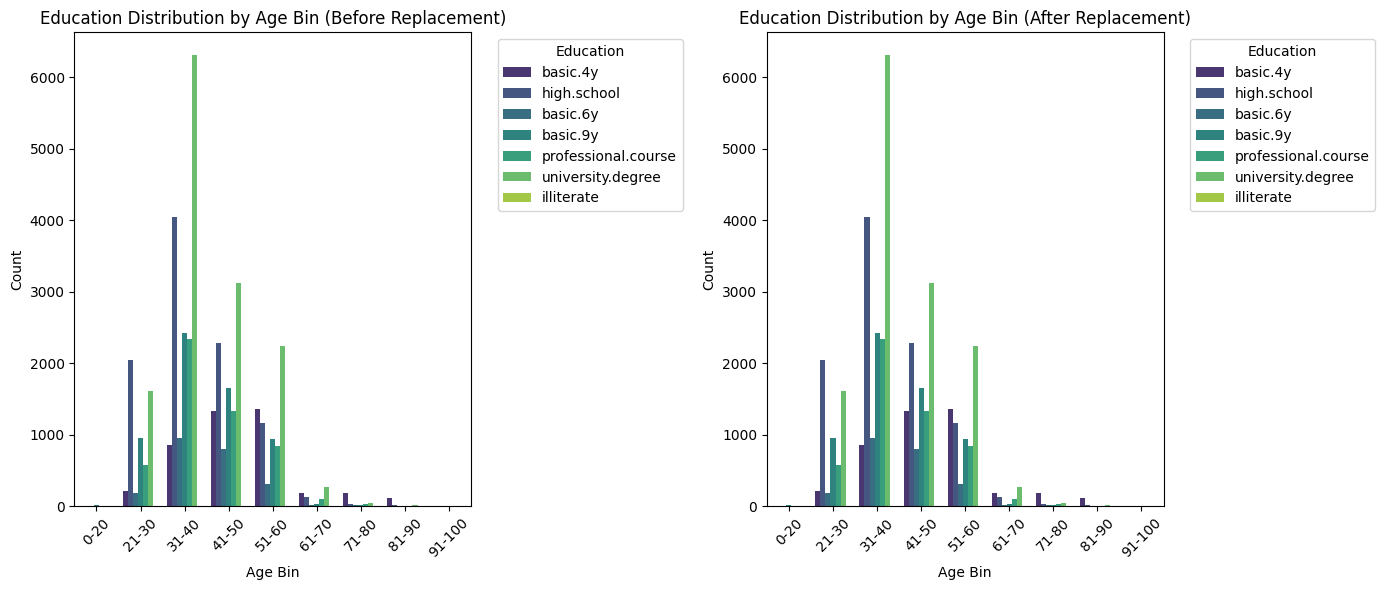

In [29]:
#Education-Age

# Determine the most frequent education category for each age bin
most_frequent_education = data.groupby('age_bin')['education'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown')

# Print the most frequent education category for each age bin
print("Most frequent education category for each age bin:\n", most_frequent_education)

# Function to replace 'unknown' labels based on age bin
def replace_unknown_education(row):
    if row['education'] == 'unknown':
        return most_frequent_education[row['age_bin']]
    return row['education']

# Replace 'unknown' labels in 'education'
data['education'] = data.apply(replace_unknown_education, axis=1)

# Verify the changes
print("Education distribution after replacement:\n", data['education'].value_counts())

# Visualize the education distribution before and after replacement
plt.figure(figsize=(14, 6))

# Before replacement
plt.subplot(1, 2, 1)
sns.countplot(data=data[data['education'] != 'unknown'], x='age_bin', hue='education', palette='viridis')
plt.title('Education Distribution by Age Bin (Before Replacement)')
plt.xlabel('Age Bin')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Education', bbox_to_anchor=(1.05, 1), loc='upper left')

# After replacement
plt.subplot(1, 2, 2)
sns.countplot(data=data, x='age_bin', hue='education', palette='viridis')
plt.title('Education Distribution by Age Bin (After Replacement)')
plt.xlabel('Age Bin')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Education', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Correlation results for 'housing':
job: Chi2 = 20.132394599913372, p-value = 0.028025035429566844, Cramer's V = 0.022121551007050665
marital: Chi2 = 7.643079576952513, p-value = 0.021894062700641825, Cramer's V = 0.013630194305826928
education: Chi2 = 15.79926270011801, p-value = 0.014872935207678187, Cramer's V = 0.019596849912620243
default: Chi2 = 0.027573897080280164, p-value = 0.8681145343380756, Cramer's V = 0.0008186851850312185
contact: Chi2 = 247.5335833681625, p-value = 8.956765728940845e-56, Cramer's V = 0.07756841560750166
month: Chi2 = 201.4296258173745, p-value = 1.661492550360626e-38, Cramer's V = 0.06997284455170197
day_of_week: Chi2 = 17.68972135154705, p-value = 0.0014188464231961006, Cramer's V = 0.02073616081572178
poutcome: Chi2 = 25.91693245256695, p-value = 2.3561862866046397e-06, Cramer's V = 0.025099187026989996

Correlation results for 'loan':
job: Chi2 = 22.22358662038466, p-value = 0.014005214524110693, Cramer's V = 0.023242076773104848
marital: Chi2 = 1.924

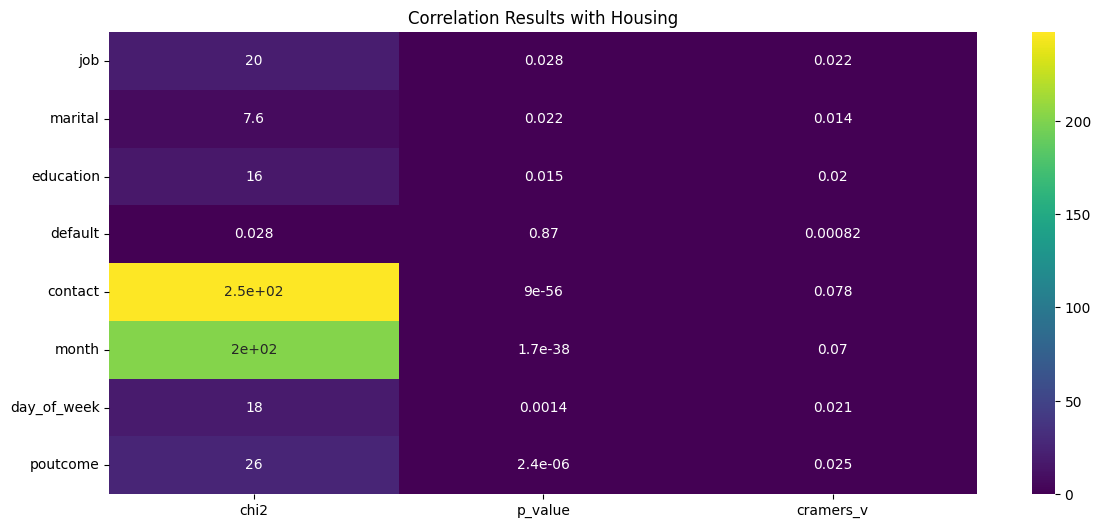

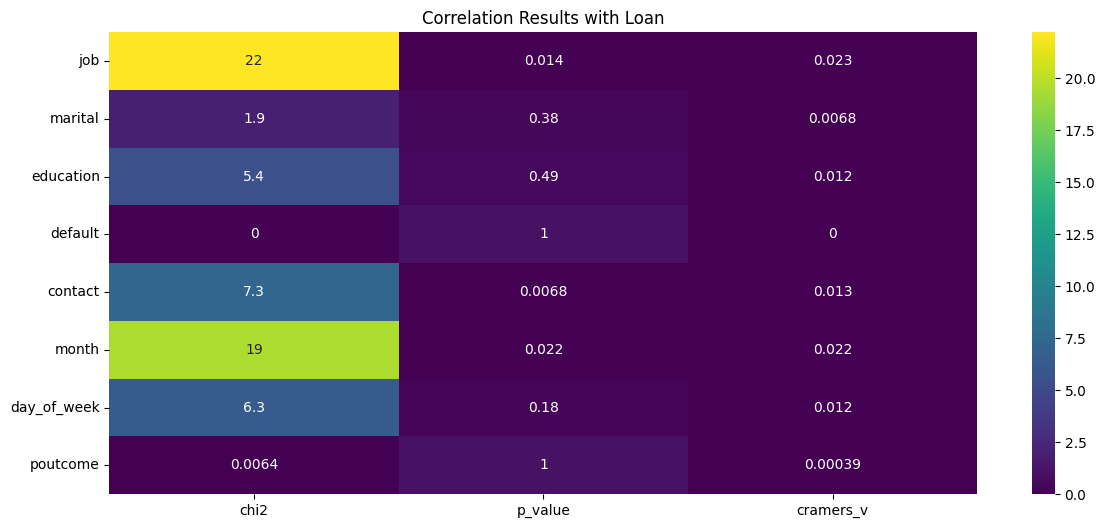

In [30]:
#Best co-relation for Housing and Loan feature

# List of categorical features to analyze
categorical_features = ['job', 'marital', 'education', 'default', 'contact', 'month', 'day_of_week', 'poutcome']

# Function to calculate Chi-Square and Cramer's V for correlation
def calculate_chi2_cramers_v(feature1, feature2):
    contingency_table = pd.crosstab(data[feature1], data[feature2])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    cramers_v = (chi2 / n) ** 0.5
    return chi2, p, cramers_v

# Dictionary to store the correlation results
correlation_results_housing = {}
correlation_results_loan = {}

# Calculate correlations for 'housing'
for feature in categorical_features:
    chi2, p, cramers_v = calculate_chi2_cramers_v('housing', feature)
    correlation_results_housing[feature] = {'chi2': chi2, 'p_value': p, 'cramers_v': cramers_v}

# Calculate correlations for 'loan'
for feature in categorical_features:
    chi2, p, cramers_v = calculate_chi2_cramers_v('loan', feature)
    correlation_results_loan[feature] = {'chi2': chi2, 'p_value': p, 'cramers_v': cramers_v}

# Print the correlation results for 'housing'
print("Correlation results for 'housing':")
for feature, results in correlation_results_housing.items():
    print(f"{feature}: Chi2 = {results['chi2']}, p-value = {results['p_value']}, Cramer's V = {results['cramers_v']}")

# Print the correlation results for 'loan'
print("\nCorrelation results for 'loan':")
for feature, results in correlation_results_loan.items():
    print(f"{feature}: Chi2 = {results['chi2']}, p-value = {results['p_value']}, Cramer's V = {results['cramers_v']}")

# Identify the best correlating feature for 'housing'
best_feature_housing = max(correlation_results_housing, key=lambda k: correlation_results_housing[k]['cramers_v'])
print(f"\nBest feature for 'housing': {best_feature_housing} with Cramer's V: {correlation_results_housing[best_feature_housing]['cramers_v']}")

# Identify the best correlating feature for 'loan'
best_feature_loan = max(correlation_results_loan, key=lambda k: correlation_results_loan[k]['cramers_v'])
print(f"Best feature for 'loan': {best_feature_loan} with Cramer's V: {correlation_results_loan[best_feature_loan]['cramers_v']}")

# Visualize the correlations for 'housing'
plt.figure(figsize=(14, 6))
sns.heatmap(pd.DataFrame(correlation_results_housing, index=['chi2', 'p_value', 'cramers_v']).T, annot=True, cmap='viridis')
plt.title('Correlation Results with Housing')
plt.show()

# Visualize the correlations for 'loan'
plt.figure(figsize=(14, 6))
sns.heatmap(pd.DataFrame(correlation_results_loan, index=['chi2', 'p_value', 'cramers_v']).T, annot=True, cmap='viridis')
plt.title('Correlation Results with Loan')
plt.show()


Most frequent answer for 'housing' for each job category:
 job
admin.           yes
blue-collar      yes
entrepreneur     yes
housemaid        yes
management       yes
retired          yes
self-employed    yes
services         yes
student          yes
technician       yes
unemployed       yes
Name: housing, dtype: object
Housing distribution after replacement:
 housing
yes    22533
no     18607
Name: count, dtype: int64


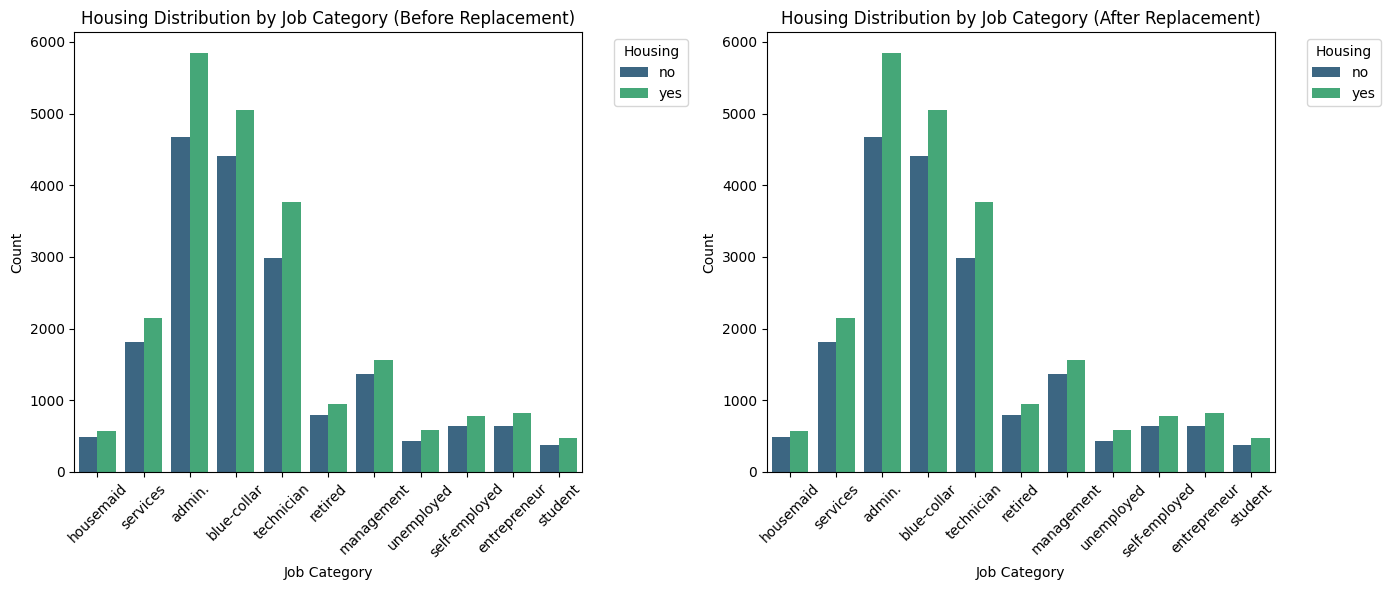

In [31]:
#Job-Housing

# Determine the most frequent answer for 'housing' for each job category
most_frequent_housing = data.groupby('job')['housing'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown')

# Print the most frequent answer for 'housing' for each job category
print("Most frequent answer for 'housing' for each job category:\n", most_frequent_housing)

# Function to replace 'unknown' labels based on job category
def replace_unknown_housing(row):
    if row['housing'] == 'unknown':
        return most_frequent_housing[row['job']]
    return row['housing']

# Replace 'unknown' labels in 'housing'
data['housing'] = data.apply(replace_unknown_housing, axis=1)

# Verify the changes
print("Housing distribution after replacement:\n", data['housing'].value_counts())

# Visualize the housing distribution before and after replacement
plt.figure(figsize=(14, 6))

# Before replacement
plt.subplot(1, 2, 1)
sns.countplot(data=data[data['housing'] != 'unknown'], x='job', hue='housing', palette='viridis')
plt.title('Housing Distribution by Job Category (Before Replacement)')
plt.xlabel('Job Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Housing', bbox_to_anchor=(1.05, 1), loc='upper left')

# After replacement
plt.subplot(1, 2, 2)
sns.countplot(data=data, x='job', hue='housing', palette='viridis')
plt.title('Housing Distribution by Job Category (After Replacement)')
plt.xlabel('Job Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Housing', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Most frequent answer for 'loan' for each job category:
 job
admin.           no
blue-collar      no
entrepreneur     no
housemaid        no
management       no
retired          no
self-employed    no
services         no
student          no
technician       no
unemployed       no
Name: loan, dtype: object
Loan distribution after replacement:
 loan
no     34897
yes     6243
Name: count, dtype: int64


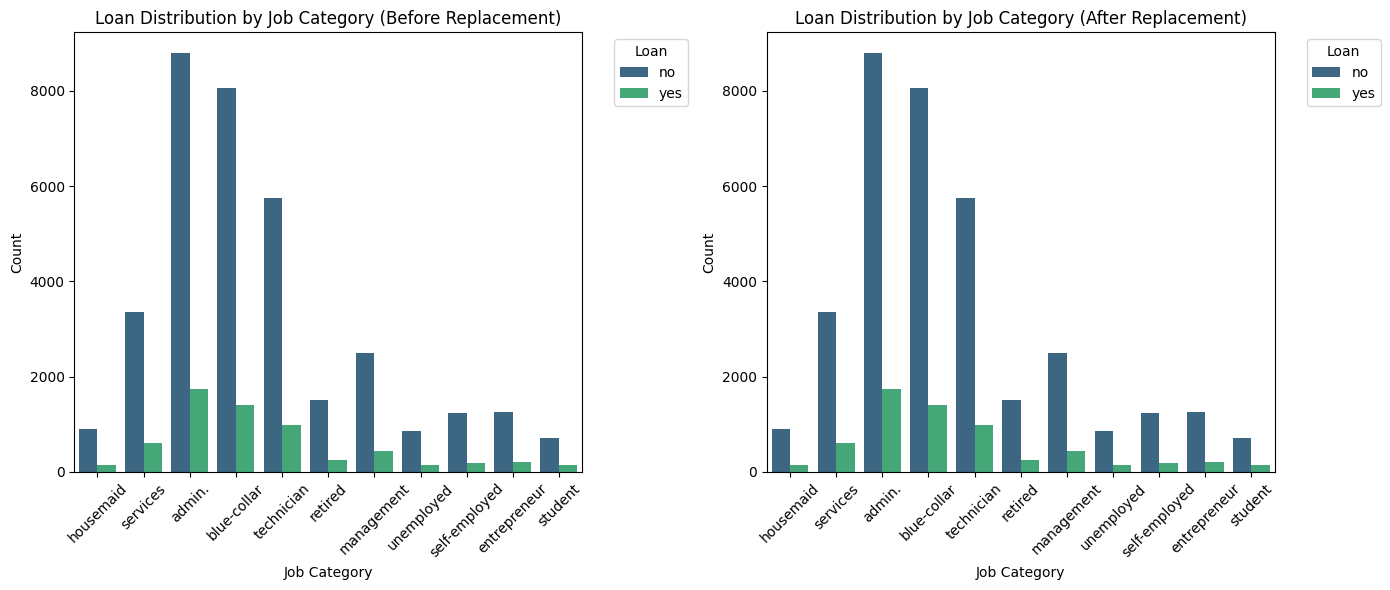

In [32]:
#Job-Loan

# Determine the most frequent answer for 'loan' for each job category
most_frequent_loan = data.groupby('job')['loan'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown')

# Print the most frequent answer for 'loan' for each job category
print("Most frequent answer for 'loan' for each job category:\n", most_frequent_loan)

# Function to replace 'unknown' labels based on job category
def replace_unknown_loan(row):
    if row['loan'] == 'unknown':
        return most_frequent_loan[row['job']]
    return row['loan']

# Replace 'unknown' labels in 'loan'
data['loan'] = data.apply(replace_unknown_loan, axis=1)

# Verify the changes
print("Loan distribution after replacement:\n", data['loan'].value_counts())

# Visualize the loan distribution before and after replacement
plt.figure(figsize=(14, 6))

# Before replacement
plt.subplot(1, 2, 1)
sns.countplot(data=data[data['loan'] != 'unknown'], x='job', hue='loan', palette='viridis')
plt.title('Loan Distribution by Job Category (Before Replacement)')
plt.xlabel('Job Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Loan', bbox_to_anchor=(1.05, 1), loc='upper left')

# After replacement
plt.subplot(1, 2, 2)
sns.countplot(data=data, x='job', hue='loan', palette='viridis')
plt.title('Loan Distribution by Job Category (After Replacement)')
plt.xlabel('Job Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Loan', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [33]:
# List of features to check for "unknown" values
features_to_check = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# Dictionary to store the count of "unknown" values for each feature
unknown_counts = {}

# Check for "unknown" values and count them
for feature in features_to_check:
    unknown_count = data[data[feature] == 'unknown'].shape[0]
    if unknown_count > 0:
        unknown_counts[feature] = unknown_count

# Print the feature names and the count of "unknown" values
if unknown_counts:
    print("Features with 'unknown' values and their counts:")
    for feature, count in unknown_counts.items():
        print(f"{feature}: {count}")
else:
    print("No 'unknown' values found in the specified features.")

# Delete records that have "unknown" values in any of the specified features
data = data[~data[features_to_check].isin(['unknown']).any(axis=1)]

# Verify the changes
print("\nDataFrame after removing records with 'unknown' values:")
print(data.head())
print("\nNumber of rows after removing records with 'unknown' values:", data.shape[0])

No 'unknown' values found in the specified features.

DataFrame after removing records with 'unknown' values:
   age        job  marital    education default housing loan    contact month  \
0   56  housemaid  married     basic.4y      no      no   no  telephone   may   
1   57   services  married  high.school      no      no   no  telephone   may   
2   37   services  married  high.school      no     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no      no   no  telephone   may   
4   56   services  married  high.school      no      no  yes  telephone   may   

  day_of_week  ...  pdays  previous     poutcome  emp.var.rate cons.price.idx  \
0         mon  ...    999         0  nonexistent           1.1         93.994   
1         mon  ...    999         0  nonexistent           1.1         93.994   
2         mon  ...    999         0  nonexistent           1.1         93.994   
3         mon  ...    999         0  nonexistent           1.1         93.994  

In [34]:
#Check for duplicate rows and handle them
duplicates = data[data.duplicated(keep=False)]
print("Duplicate rows:\n", duplicates)
print("Count of duplicate rows:", duplicates.shape[0])

#Remove duplicates
data = data.drop_duplicates()
print("Final dataset count after removing duplicates:", data.shape[0])

Duplicate rows:
 Empty DataFrame
Columns: [age, job, marital, education, default, housing, loan, contact, month, day_of_week, duration, campaign, pdays, previous, poutcome, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed, y, age_bin]
Index: []

[0 rows x 22 columns]
Count of duplicate rows: 0
Final dataset count after removing duplicates: 41140


<ipython-input-25-d7a41212fbcb>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=feature, y='age', ax=axes[i], palette=palette)
<ipython-input-25-d7a41212fbcb>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=feature, y='age', ax=axes[i], palette=palette)
<ipython-input-25-d7a41212fbcb>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=feature, y='age', ax=axes[i], palette=palette)
<ipython-input-25-d7a41212fbcb>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be 

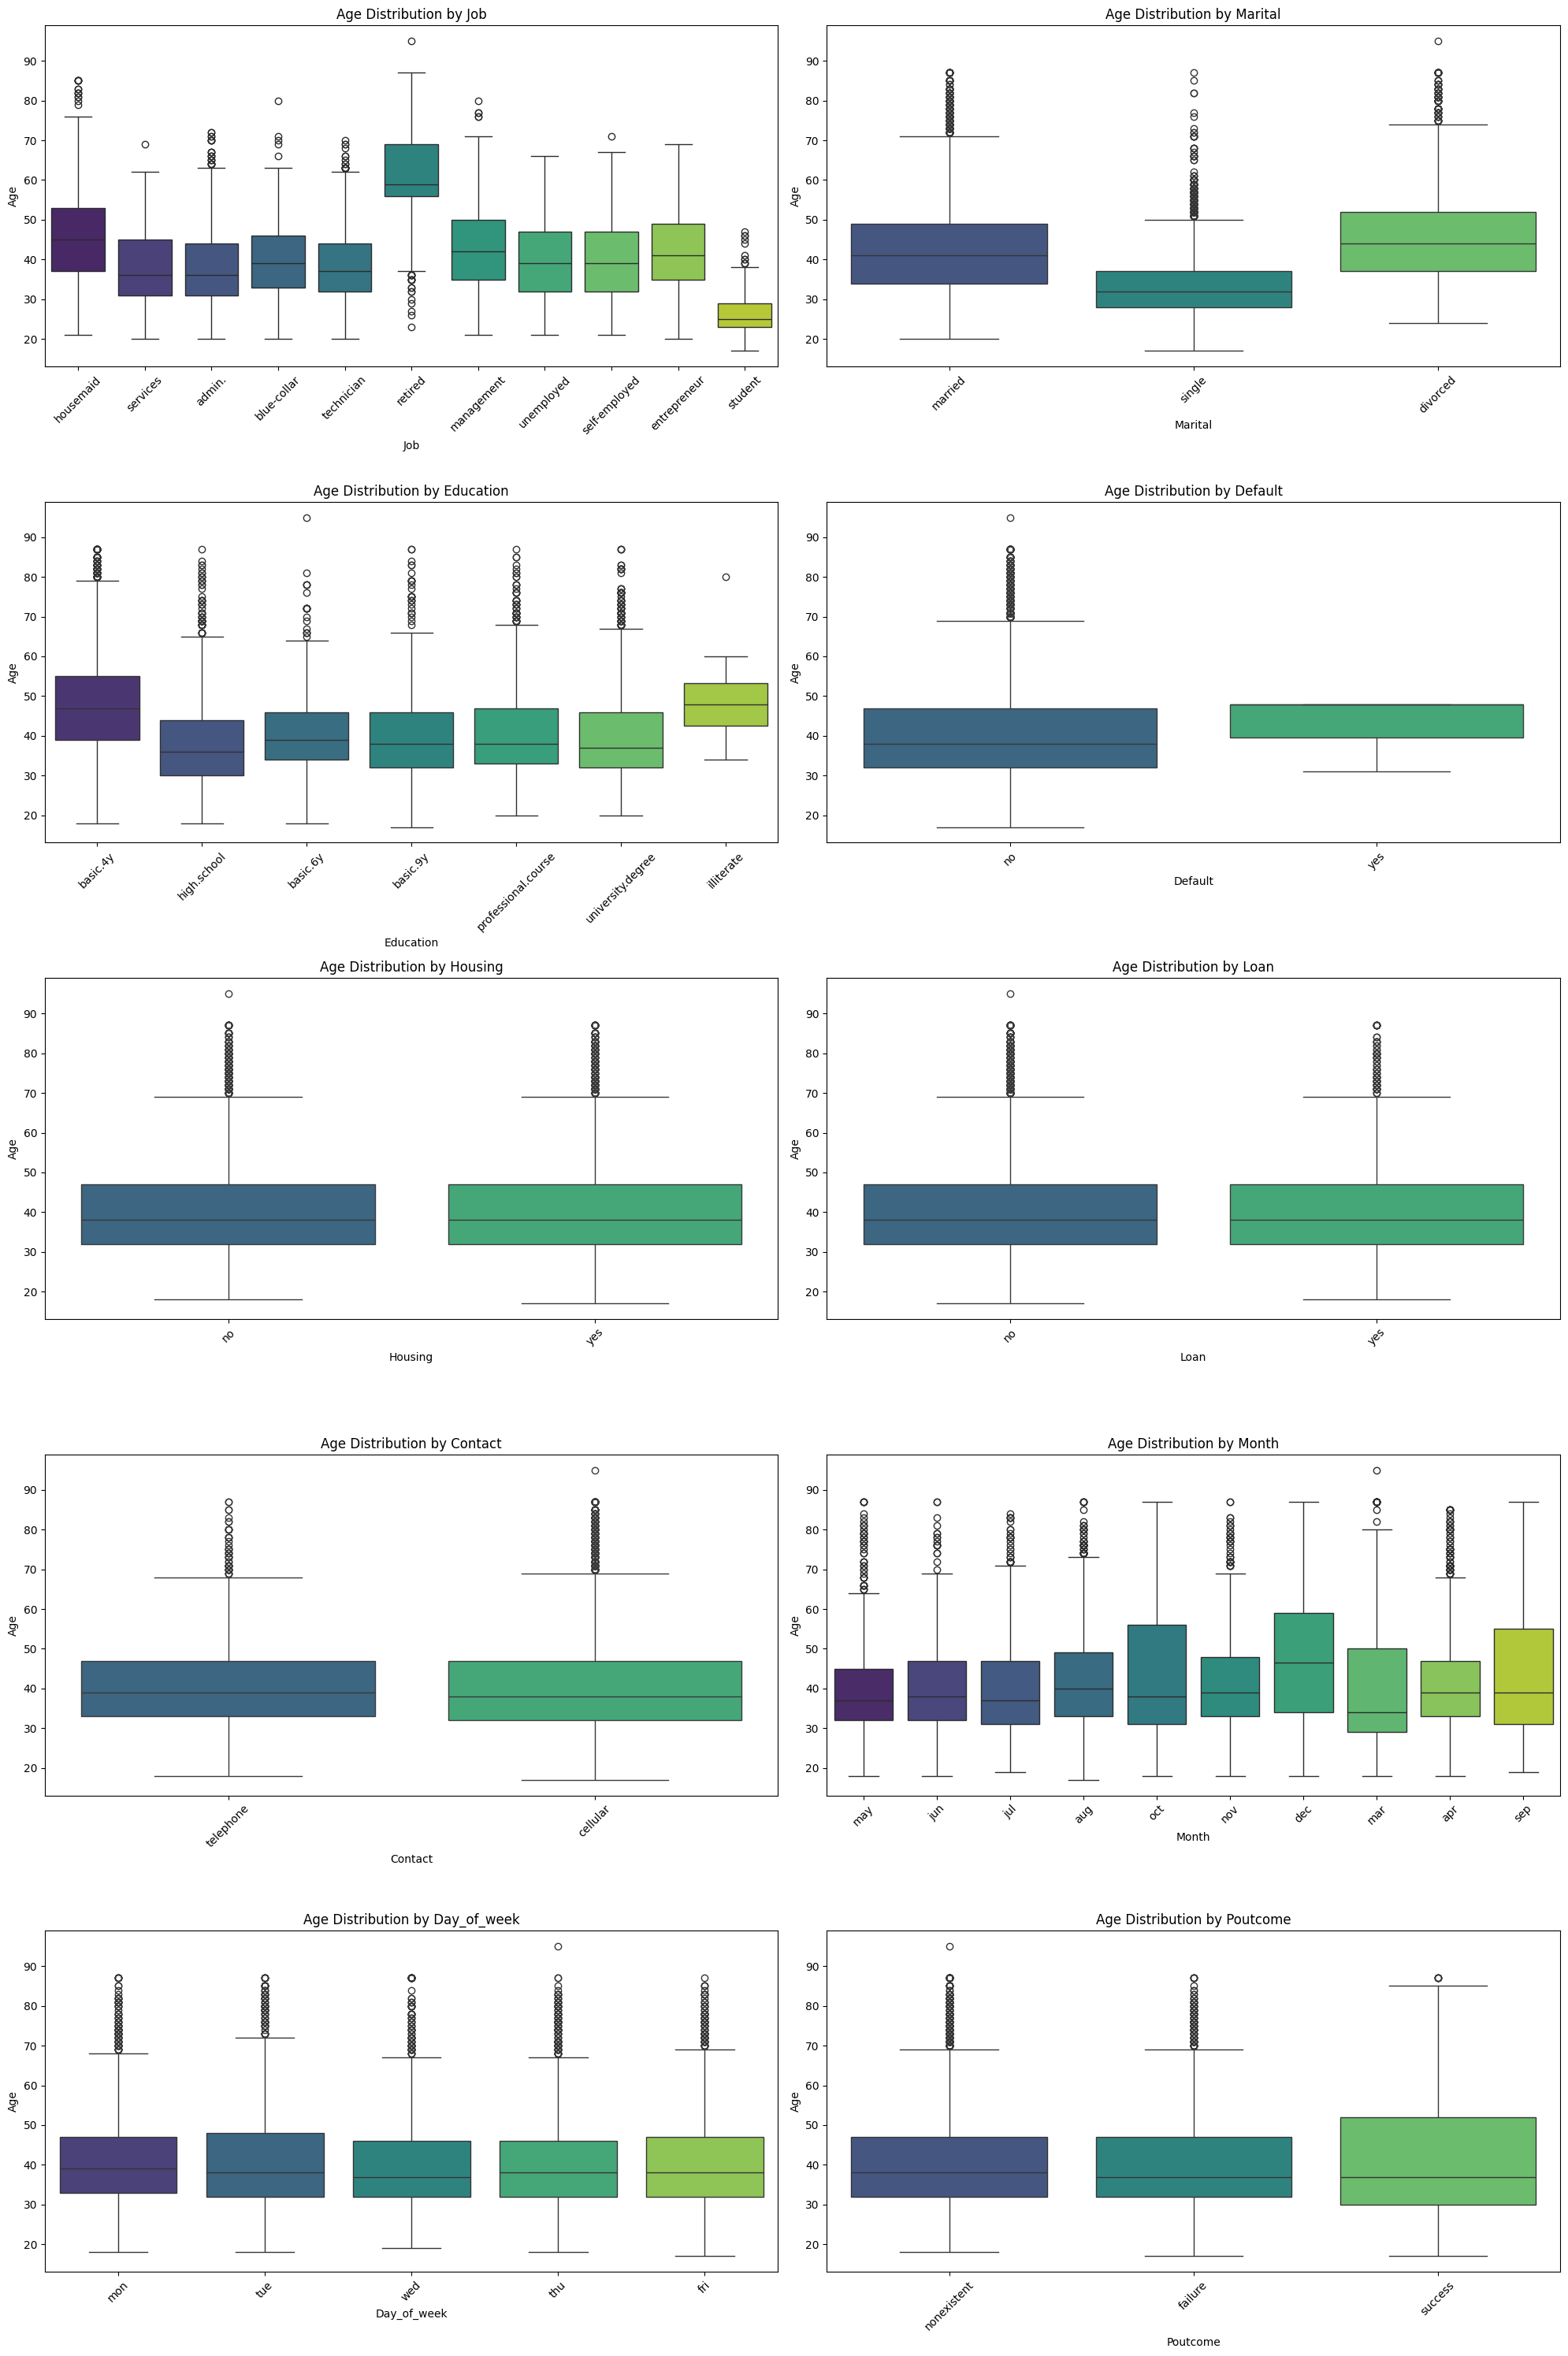

In [25]:
# List of categorical features to plot
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# Define a color palette for the plots
palette = 'viridis'

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))
axes = axes.flatten()

# Plot box plots for each categorical feature
for i, feature in enumerate(categorical_features):
    sns.boxplot(data=data, x=feature, y='age', ax=axes[i], palette=palette)
    axes[i].set_title(f'Age Distribution by {feature.capitalize()}')
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel('Age')
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

<ipython-input-35-67244dee71eb>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


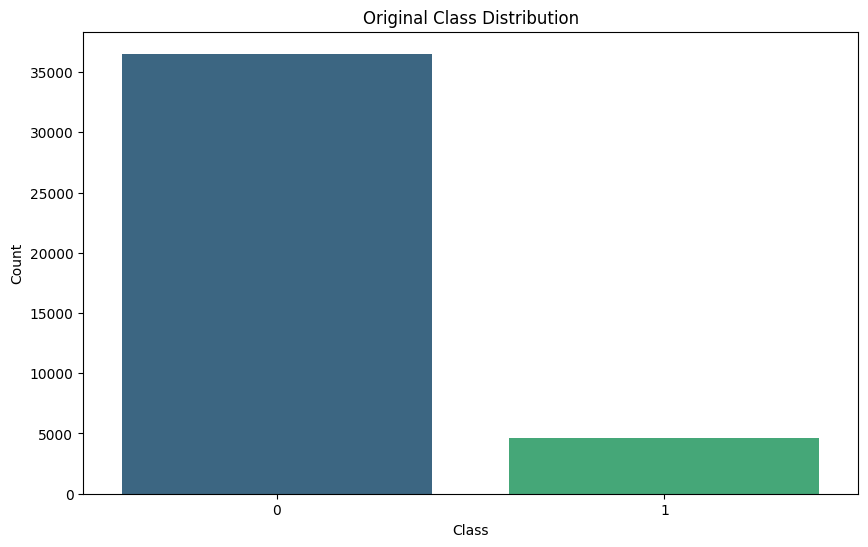

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
<ipython-input-35-67244dee71eb>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `l

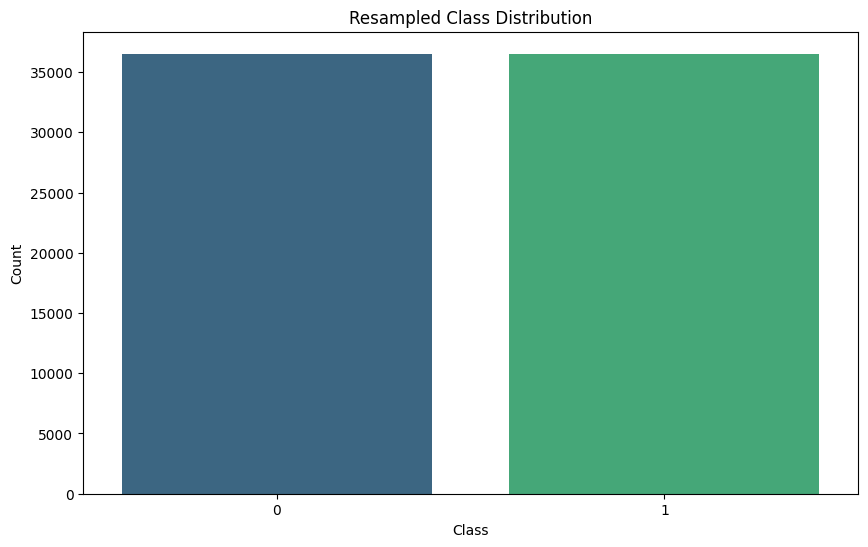

Original class distribution:
0    36519
1     4621
Name: count, dtype: int64
Resampled class distribution:
0    36519
1    36519
Name: count, dtype: int64


In [35]:
# Separate features and target variable
X = data.drop(columns=['y', 'age_bin'])  # Drop 'age_bin' as it's not needed for modeling
y = data['y']

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Apply the preprocessor
X_processed = preprocessor.fit_transform(X)

# Visualize the original class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y, palette='viridis')
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)

# Visualize the resampled class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_resampled, palette='viridis')
plt.title('Resampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Verify the new class distribution
print(f"Original class distribution:\n{pd.Series(y).value_counts()}")
print(f"Resampled class distribution:\n{pd.Series(y_resampled).value_counts()}")



In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Evaluation:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")


Random Forest Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7325
           1       0.96      0.94      0.95      7283

    accuracy                           0.95     14608
   macro avg       0.95      0.95      0.95     14608
weighted avg       0.95      0.95      0.95     14608

Accuracy: 0.9526286966046003


In [38]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype("int32")
print("Neural Network Model Evaluation:")
print(classification_report(y_test, y_pred_nn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn)}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8605 - loss: 0.3442 - val_accuracy: 0.9049 - val_loss: 0.2396
Epoch 2/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9120 - loss: 0.2209 - val_accuracy: 0.9160 - val_loss: 0.2118
Epoch 3/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9255 - loss: 0.1872 - val_accuracy: 0.9179 - val_loss: 0.2004
Epoch 4/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9297 - loss: 0.1700 - val_accuracy: 0.9241 - val_loss: 0.1882
Epoch 5/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9347 - loss: 0.1574 - val_accuracy: 0.9214 - val_loss: 0.1941
Epoch 6/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9395 - loss: 0.1487 - val_accuracy: 0.9234 - val_loss: 0.1905
Epoch 7/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9411 - loss: 0.1438 - val_accuracy: 0.9236 - val_loss: 0.1818
Epoch 8/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9431 - loss: 0.1366 - 

## **Visualizing**

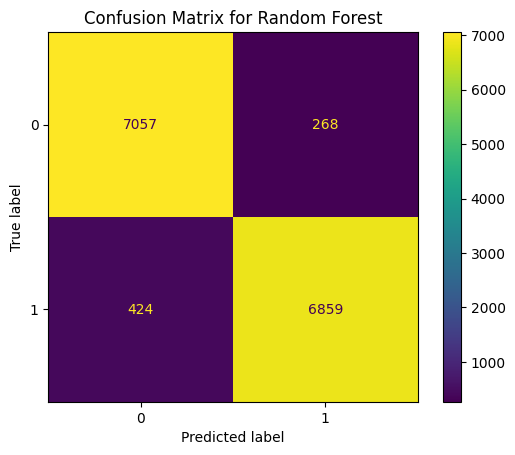

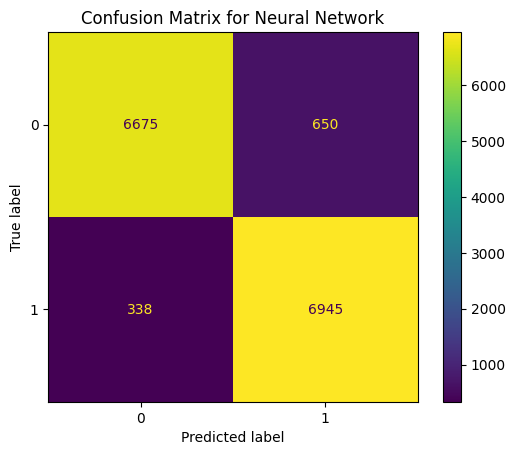

In [ ]:
# Confusion Matrix for Random Forest
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot()
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Confusion Matrix for Neural Network
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_nn)).plot()
plt.title('Confusion Matrix for Neural Network')
plt.show()

457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


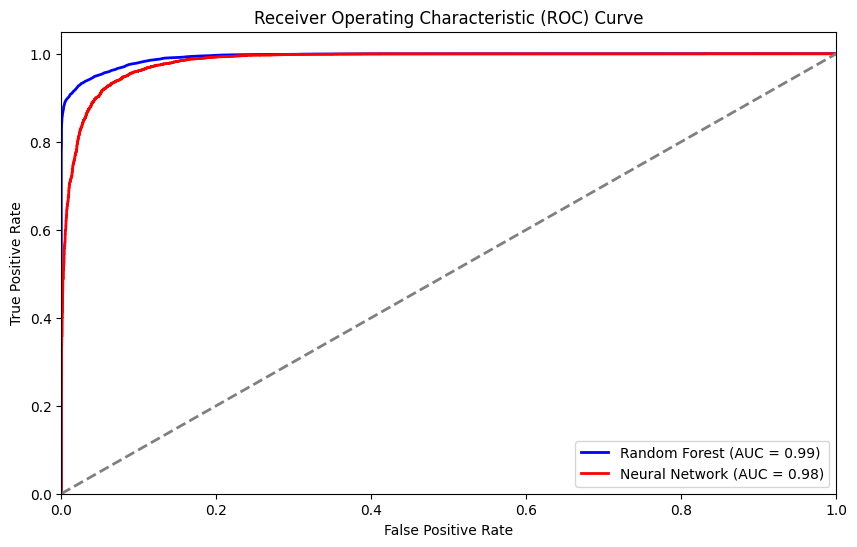

In [39]:
# ROC Curve and AUC for Random Forest
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# ROC Curve and AUC for Neural Network
y_pred_prob_nn = nn_model.predict(X_test_scaled).ravel()
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_prob_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_nn, tpr_nn, color='red', lw=2, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
